In [3]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from matplotlib import rc
rc("font", family="serif", size=11)

In [156]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
ID = 7741179
ID = random.choice(output['ID'])
star = output.loc[(output['ID'] == ID)]


star

,ID,Numax,Numax_err
959,4569298,35.748228,0.042177


In [157]:
modes = pd.read_csv('../data/rgbmodes/modes_'+str(ID)+'.csv', usecols=['f0', 'f0_err', 'A0'])

modes = modes.sort_values(by=['f0'])
modes = modes.set_index(np.arange(0,len(modes),1))
modes['dnu'] = (modes['f0'].diff(2).shift(-1))/2
dnu_avg = np.mean(modes['dnu'])
n_min = int(modes['f0'].min() / dnu_avg)

n = np.arange(n_min, n_min+len(modes), 1)
modes.insert(loc=0, column='n', value=n)


modes

,n,f0,A0,f0_err,dnu
0,6,25.200413,-1.149897,0.047392,NaN
1,7,28.826901,-0.552041,0.030322,3.733774
2,8,32.667961,0.344409,0.016403,4.059090
3,9,36.945081,0.611069,0.018048,4.172417
4,10,41.012796,0.562926,0.021625,4.150914
5,11,45.246909,-0.197921,0.072103,4.231952
6,12,49.476699,-0.723868,0.065280,NaN


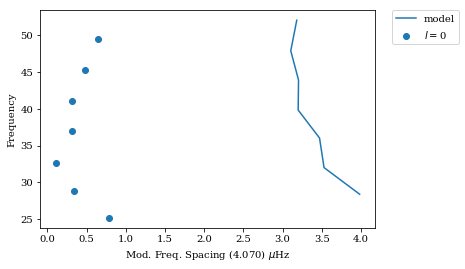

In [165]:
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], label=r'$l=$'+str(0))

def model(n, dnu, nmax, epsilon, k, A, omega, phi, tau):
    freqs = (n + epsilon) * dnu
    freqs += (nmax-n)**2 * k
    freqs += A*np.sin(omega*n + phi)*np.exp(-n/tau)
    return freqs

nmax = 11
numax = star.iloc[0]['Numax']
epsilon = 0.77
k = 0.03
A = 0.2
omega = 3
phi = 2
tau = 10

f = model(n, dnu_avg, nmax, epsilon, k, A, omega, phi, tau)

plt.plot(f % dnu_avg, f, label='model')
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [201]:
code = '''
functions {
    real model(real n, real dnu, real nmax, real epsilon, real k, real A, real omega, real phi, real tau){
        return (dnu*(n+epsilon) + k*(nmax - n)^2 + A*sin(omega*n + phi)*exp(-n/tau));
    }
}
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
    real numax;
}
parameters {
    real<lower = 0> dnu;
    real<lower = 0> nmax;
    real epsilon;
    real k;
    real<lower = 0> A;
    real<lower = 0> omega;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = model(n[i], dnu, nmax, epsilon, k, A, omega, phi, tau);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    nmax ~ normal(9,1.7);
    // epsilon ~ normal(0.4, 0.4);
    epsilon ~ normal(numax/dnu - nmax, 0.4);
    k ~ lognormal(log(0.04), 0.003);
    A ~ lognormal(log(0.2), 0.01);
    omega ~ normal(3, 0.3);
    tau ~ normal(8,1.6);
    // phi ~ normal(0, 1.5);
    
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34650bfe90de9ab23edd0704a00a9434 NOW.


In [202]:
stan_data = {'N': len(modes['n'].values),
             'n': modes['n'].values, 
             'freq': (modes['f0'].values),
             'freq_err': modes['f0_err'].values,
             'dnu_guess': dnu_avg,
             'numax': star.iloc[0]['Numax']
            }
start = {'dnu': dnu_avg,
         'nmax': nmax,
         'epsilon': epsilon,
         'k': k,
         'A': A,
         'omega': omega,
         'phi': phi,
         'tau': tau
        }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)],)
                  #control=dict(max_treedepth=15))

In [203]:
print(fit)

Inference for Stan model: anon_model_34650bfe90de9ab23edd0704a00a9434.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.07  4.8e-5 4.1e-3   4.06   4.07   4.07   4.07   4.08   7266    1.0
nmax      8.68  1.3e-3   0.11   8.47   8.61   8.68   8.76   8.89   7413    1.0
epsilon   0.06  1.1e-4 9.0e-3   0.04   0.05   0.06   0.06   0.07   7220    1.0
k         0.04  1.2e-6 1.2e-4   0.04   0.04   0.04   0.04   0.04   9791    1.0
A          0.2  2.1e-5 2.0e-3    0.2    0.2    0.2    0.2    0.2   9014    1.0
omega     2.25  6.7e-4   0.04   2.19   2.22   2.24   2.28   2.36   4424    1.0
phi       5.93  5.1e-3   0.33   5.09   5.77   6.02   6.17   6.27   4138    1.0
tau      10.94    0.01   1.14   8.82  10.15  10.92  11.67  13.27   8041    1.0
lp__    -16.69    0.03   2.04 -21.58 -17.84 -16.36 -15.18 -13.72   3777    1.0

Samples were drawn 

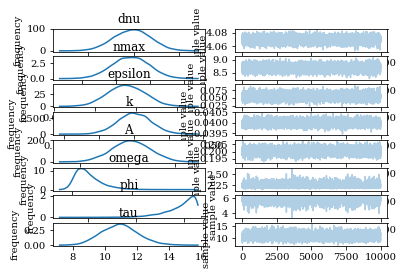

In [204]:
fit.plot()
plt.show()

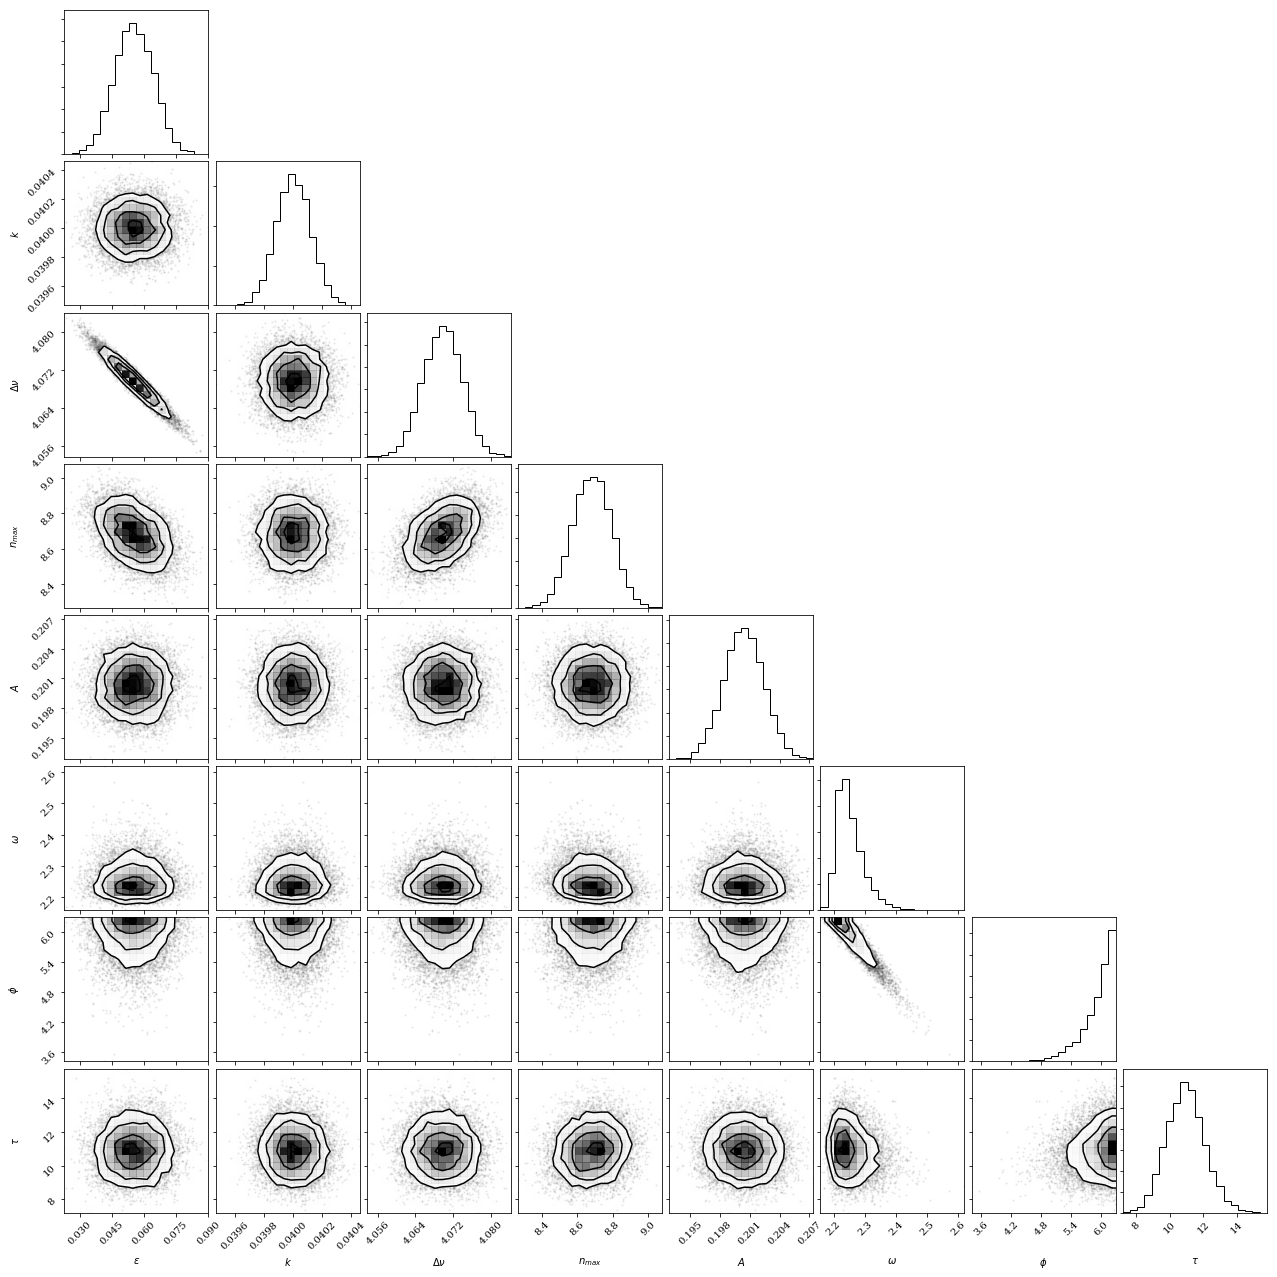

In [205]:
import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['A'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

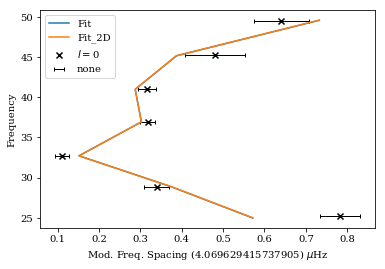

In [206]:
#n = np.arange(12,30,1)

plt.figure(4)
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], c='k', marker='x', label=r'$l=$'+str(0))
plt.errorbar(modes['f0'] % dnu_avg, modes['f0'], xerr=modes['f0_err'], zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)

#g = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
#          fit['A'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
g2 = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
          fit['A'].mean(), np.median(fit['omega']), fit['phi'].mean(), fit['tau'].mean())
#plt.plot(f % dnu_avg, f, ':', label='Guess')
plt.plot(g % fit['dnu'].mean(), g, label='Fit')
plt.plot(g2 % fit['dnu'].mean(), g2, label='Fit_2D')
#plt.plot(g % dnu, g, label='Fit')

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(dnu_avg) +') $\mu$Hz')
#plt.xlim(58,68)
plt.legend()
plt.show()